In [1]:
import PyPlot; plt = PyPlot

using PyCall
const tf = pyimport("tensorflow")
tf.compat.v1.enable_eager_execution()
slim = tf.contrib.slim

In [242]:
function make_scale_matrix(n_gen, n_orig)
    s1 =  tf.constant(1.0 / n_gen,  shape=[n_gen, 1])
    s2 = -tf.constant(1.0 / n_orig, shape=[n_orig, 1])
    return tf.concat([s1, s2], 0)
end

params = (batch_size=10, latend_dim=1)

function compute_ratio(x, x_gen, sigma=[1])
    X = tf.concat([x_gen, x], 0)
    XX = tf.matmul(X, tf.transpose(X))
    X2 = tf.reduce_sum(X * X, 1, keep_dims=true)
    exponent = XX - 0.5 * X2 - 0.5 * tf.transpose(X2)
    s = make_scale_matrix(params.batch_size, params.batch_size)
    S = tf.matmul(s, tf.transpose(s))
    n = params.batch_size
    kernel_val = tf.exp(1.0 / sigma[1] * exponent)
    k_de_de = py"$kernel_val[:$n,:$n]"
    k_de_nu = py"$kernel_val[:$n,$n:]"
    k_nu_nu = py"$kernel_val[$n:,$n:]"
#     eps = tf.diag(tf.ones(params.batch_size) * 1f-3)
    return (
        inv=tf.linalg.inv(k_de_de),
        k_de_de=k_de_de,
        k_nu_nu=k_nu_nu,
        ratio=tf.matmul(tf.matmul(tf.linalg.inv(k_de_de + eps), k_de_nu), tf.ones(shape=(params.batch_size, 1))), 
        mmd=tf.sqrt(tf.reduce_sum(S * kernel_val))
    )
end

compute_ratio (generic function with 2 methods)

In [243]:
x = tf.random.normal((params.batch_size, params.latend_dim))
x_gen = tf.random.normal((params.batch_size, params.latend_dim)) + 1

ratio = compute_ratio(x, x_gen).ratio

;

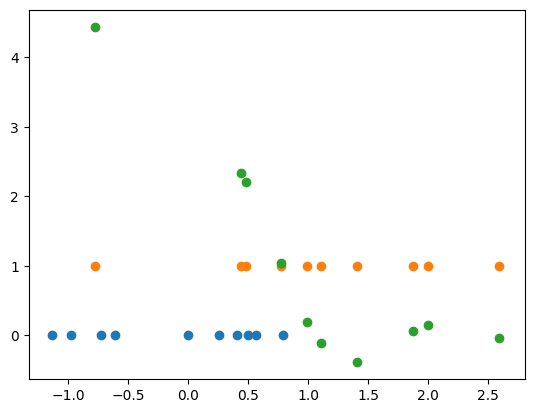

PyObject <matplotlib.collections.PathCollection object at 0x7f8949fc23c8>

In [224]:
plt.scatter(x.numpy(), zeros(params.batch_size))
plt.scatter(x_gen.numpy(), ones(params.batch_size))
plt.scatter(x_gen.numpy(), ratio.numpy())

In [236]:
x = x.numpy()
x_gen = x_gen.numpy()

10×1 Array{Float32,2}:
  0.1328491 
  2.2417107 
 -0.10573971
  1.4419965 
  1.6975646 
  0.1274457 
  0.76847845
  0.84680796
  0.36343694
  2.8554459 

In [237]:
using RMMMDNets

In [238]:
sqrt(RMMMDNets.compute_mmd(x', x_gen'; σs=[1]) ^ 2 - 1f-6)

0.44729865f0

In [239]:
function RMMMDNets.estimate_ratio(x_de, x_nu; σs=[], verbose=false)
    function _estimate_ratio(pdot_dede, pdot_denu, pdot_nunu, σ)
        Kdede = RMMMDNets.gaussian_gram_by_pairwise_sqd(pdot_dede, σ)
        Kdenu = RMMMDNets.gaussian_gram_by_pairwise_sqd(pdot_denu, σ)
        @info Kdenu
        n_de, n_nu = size(Kdenu)
        return convert(Float32, n_de / n_nu) * (Kdede \ sum(Kdenu; dims=2)[:,1])
    end
    return RMMMDNets.multi_run(_estimate_ratio, x_de, x_nu, σs, verbose) / convert(Float32, length(σs))
end

ratio = RMMMDNets.estimate_ratio( x', x_gen'; σs=[1])

;

┌ Info: Float32[0.7332266 0.4178531 0.59053946 0.87292045 0.7394767 0.73010147 0.9884915 0.99727875 0.8562158 0.15385365; 0.99145454 0.14143115 0.93397766 0.49957365 0.35781062 0.99073845 0.88045293 0.8437383 0.9950547 0.03479947; 0.4864651 0.0041864202 0.62962645 0.042888816 0.021858063 0.48962379 0.1853202 0.1600034 0.3591575 0.0004549552; 0.6307761 0.009014065 0.7708818 0.07619001 0.04129122 0.6340474 0.2799838 0.24633163 0.49225667 0.0011353935; 0.6187533 0.008479907 0.7597767 0.07282148 0.03926604 0.62202895 0.2712052 0.23823763 0.48066992 0.001055185; 0.9958034 0.13075256 0.94691217 0.47660083 0.3379452 0.9952955 0.8624969 0.82399046 0.99040294 0.031405237; 0.5379559 0.005561344 0.6819736 0.053147092 0.027694825 0.54119456 0.21658203 0.18827255 0.4052174 0.0006375048; 0.9769743 0.1666679 0.9018961 0.5501012 0.40263563 0.97582126 0.9156614 0.88332886 0.99989134 0.04320076; 0.99418145 0.1351111 0.9416956 0.48610127 0.34612253 0.9935868 0.8700722 0.83229095 0.99251825 0.03277882; 0.

In [ ]:
┌ Info: PyObject <tf.Tensor: id=3867, shape=(10, 10), dtype=float32, numpy=
│ array([[7.3322660e-01, 9.9145454e-01, 4.8646510e-01, 6.3077611e-01,
│         6.1875331e-01, 9.9580342e-01, 5.3795588e-01, 9.7697431e-01,
│         9.9418145e-01, 6.1812133e-02],
│        [4.1785312e-01, 1.4143112e-01, 4.1864202e-03, 9.0140654e-03,
│         8.4799072e-03, 1.3075256e-01, 5.5613439e-03, 1.6666788e-01,
│         1.3511109e-01, 9.6907449e-01],
│        [5.9053946e-01, 9.3397766e-01, 6.2962645e-01, 7.7088177e-01,
│         7.5977665e-01, 9.4691217e-01, 6.8197358e-01, 9.0189612e-01,
│         9.4169557e-01, 3.4215655e-02],
│        [8.7292051e-01, 4.9957365e-01, 4.2888828e-02, 7.6190010e-02,
│         7.2821498e-02, 4.7660086e-01, 5.3147092e-02, 5.5010122e-01,
│         4.8610130e-01, 5.7600659e-01],
│        [7.3947662e-01, 3.5781068e-01, 2.1858068e-02, 4.1291218e-02,
│         3.9266028e-02, 3.3794519e-01, 2.7694825e-02, 4.0263563e-01,
│         3.4612256e-01, 7.2916675e-01],
│        [7.3010147e-01, 9.9073845e-01, 4.8962376e-01, 6.3404739e-01,
│         6.2202889e-01, 9.9529552e-01, 5.4119456e-01, 9.7582126e-01,
│         9.9358678e-01, 6.1028175e-02],
│        [9.8849148e-01, 8.8045293e-01, 1.8532020e-01, 2.7998379e-01,
│         2.7120519e-01, 8.6249691e-01, 2.1658203e-01, 9.1566139e-01,
│         8.7007219e-01, 2.2630060e-01],
│        [9.9727875e-01, 8.4373832e-01, 1.6000339e-01, 2.4633163e-01,
│         2.3823763e-01, 8.2399046e-01, 1.8827255e-01, 8.8332886e-01,
│         8.3229095e-01, 2.5822404e-01],
│        [8.5621578e-01, 9.9505472e-01, 3.5915750e-01, 4.9225667e-01,
│         4.8066992e-01, 9.9040294e-01, 4.0521744e-01, 9.9989134e-01,
│         9.9251825e-01, 1.0370907e-01],
│        [1.5385361e-01, 3.4799471e-02, 4.5495521e-04, 1.1353940e-03,
│         1.0551850e-03, 3.1405244e-02, 6.3750474e-04, 4.3200761e-02,
│         3.2778826e-02, 9.3621099e-01]], dtype=float32)>
└ @ Main In[233]:21